<a href="https://colab.research.google.com/github/letianzj/QuantResearch/blob/master/notebooks/gaussian_mixture_markov_switching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
from datetime import datetime, timedelta
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas_datareader as pdr

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Download Data

In [31]:
end_date = datetime.today()
# start_date = end_date + timedelta(days=-5*365)
start_date = datetime(2000, 1, 1)
spx = pdr.DataReader(name='^GSPC', data_source='yahoo', start=start_date, end=end_date)
hist_close = spx['Close']
hist_ret = hist_close / hist_close.shift(1) - 1.0     # shift 1 shifts forward one day; today has yesterday's price
# hist_ret = hist_close.pct_change(1)
hist_ret.dropna(inplace=True)
hist_ret = hist_ret * 100.0
print(hist_ret.describe())

count    5156.000000
mean        0.022692
std         1.257770
min       -11.984055
25%        -0.478784
50%         0.056493
75%         0.573276
max        11.580037
Name: Close, dtype: float64


### Gaussian Mixture Model

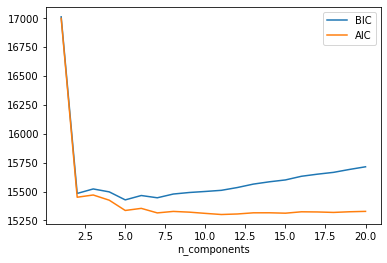

In [34]:
from sklearn.mixture import GaussianMixture

X = hist_ret.values.reshape(-1, 1)

n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X) for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

We may choose two or three states based on the AIC graph. Two states could be explained as high and low vol regimes; while three states hopefully can coincide with uptrend, downtrend and sideways.

In [41]:
# Here I choose 2 states
gmm = GaussianMixture(n_components=2, covariance_type='full')
gmm.fit(X)
labels = gmm.predict(X)

In [42]:
# the result suggests first state is low vol, second state is high vol.
print(gmm.means_, gmm.covariances_) 

[[ 0.0771677]
 [-0.18504  ]] [[[0.50395004]]

 [[5.63689172]]]


In [43]:
gmm.predict_proba(X)

array([[1.06088942e-05, 9.99989391e-01],
       [9.27256130e-01, 7.27438701e-02],
       [9.27737416e-01, 7.22625835e-02],
       ...,
       [7.04229548e-01, 2.95770452e-01],
       [6.64648042e-01, 3.35351958e-01],
       [9.17468730e-01, 8.25312697e-02]])

In [45]:
gmm_regimes = gmm.predict(X)                  # save for latter

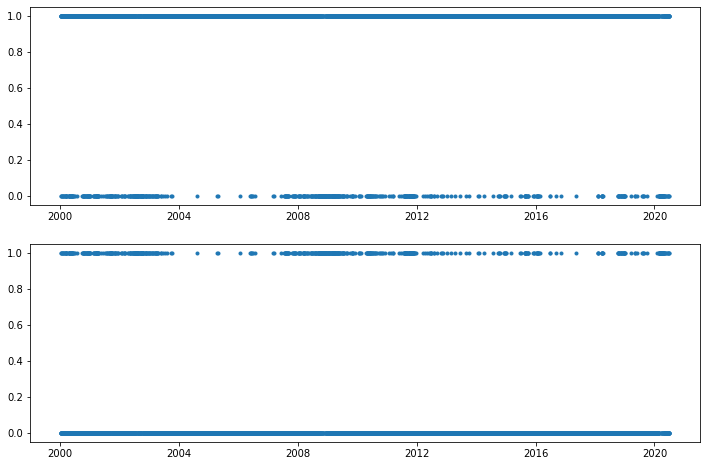

In [70]:
first_state = [1 if r == 0 else 0 for r in gmm_regimes]
second_state = [1 if r == 1 else 0 for r in gmm_regimes]
fig, axes = plt.subplots(2, figsize=(12, 8))
axes[0].plot(hist_ret.index, first_state, '.', label='first regime')
axes[1].plot(hist_ret.index, second_state, '.', label='second regime')
plt.show()

In [64]:
print(np.sum(first_state), np.sum(second_state), hist_ret.shape[0])

4539 617 5156


### Markov Regime Switching Model

In [57]:
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

In [58]:
model = MarkovRegression(hist_ret, k_regimes=2, trend='nc', switching_variance=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [59]:
# result suggest first regime is low vol; second regime is high vol.
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                  Close   No. Observations:                 5156
Model:               MarkovRegression   Log Likelihood               -7335.612
Date:                Wed, 01 Jul 2020   AIC                          14679.224
Time:                        22:33:24   BIC                          14705.416
Sample:                             0   HQIC                         14688.390
                               - 5156                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.5003      0.017     29.027      0.000       0.466       0.534
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         4.1675      0.187     22.243      0.000       3.800       4.535
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9903      0.002    468.237      0.000       0.986       0.994
p[1->0]        0.0224      0.005      4.481      0.000       0.013       0.032
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

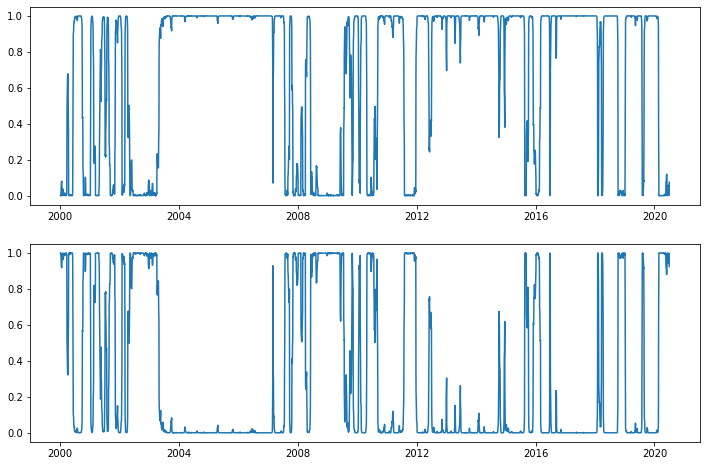

In [60]:
# Regime switch model has better results; which is expected.
# Gaussian mixture doesn't consider time sequence of historical returns.
fig, axes = plt.subplots(2, figsize=(12, 8))
axes[0].plot(res.smoothed_marginal_probabilities[0], label='first regime')
axes[1].plot(res.smoothed_marginal_probabilities[1], label='second regime')
plt.show()

In [75]:
print(np.sum(res.smoothed_marginal_probabilities[0] > 0.5), np.sum(res.smoothed_marginal_probabilities[1] > 0.5), hist_ret.shape[0])

3617 1539 5156


### Evaluation

In [76]:
# VIX shadow
vix = pdr.DataReader(name='^VIX', data_source='yahoo', start=start_date, end=end_date)

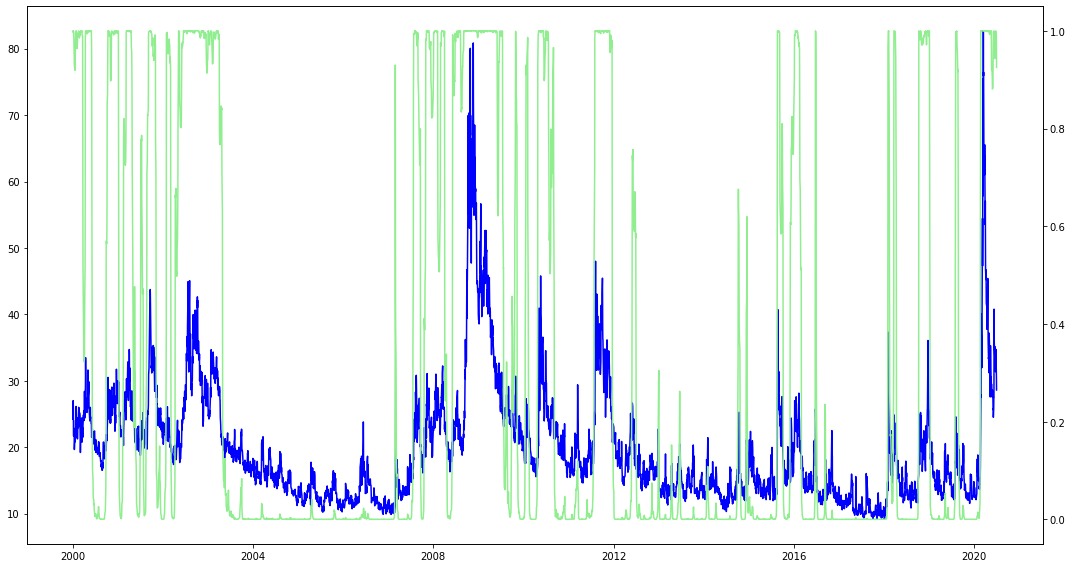

In [105]:
fig, ax1 = plt.subplots(figsize=(15,8))
ax1.plot(vix.Close, label='vix', color='blue')
ax2 = ax1.twinx()
ax2.plot(res.smoothed_marginal_probabilities[1], label='second regime', color='lightgreen')
fig.tight_layout()
plt.show()